# Лабораторная работа 2 - Знакомство с методом кластеризации K-mean с помощью пакета sklearn

Мы выбрали датасет, содержащий информацию о клиентах супермаркета через их членские карты, включая их ID, возраст, пол, годовой доход и оценку расходов. Оценка расходов представляет собой значение, основанное на поведении клиента и данных о покупках, присвоенное каждому клиенту владельцем супермаркета.

## Подключим все необходимые библиотеки:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn.cluster import KMeans
from scipy import stats

## Посмотрим на первые пять значений:

In [2]:
data = pd.read_csv("Mall_Customers.csv",index_col=0)
data.head()

,Genre,Age,Annual Income (k$),Spending Score (1-100)
CustomerID,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40


## Добавим новый аттрибут

Добавим аттрибут "Spending Income Ratio" представляющий собой отношение оценки расходов к годовым доходам.

In [3]:
data['Spending Income Ratio'] = data['Spending Score (1-100)'] / data['Annual Income (k$)']

data.head()

,Genre,Age,Annual Income (k$),Spending Score (1-100),Spending Income Ratio
CustomerID,,,,,
1,Male,19,15,39,2.600000
2,Male,21,15,81,5.400000
3,Female,20,16,6,0.375000
4,Female,23,16,77,4.812500
5,Female,31,17,40,2.352941


## Очистим датасет

### Найдём и удалим выбросы

In [4]:
# Выбор числовых признаков для анализа выбросов
features_to_analyze = ["Age", "Annual Income (k$)", "Spending Score (1-100)", "Spending Income Ratio"]

# Функция для определения выбросов по стандартным отклонениям
def find_outliers_std(series):
    std_dev = series.std()  # Стандартное отклонение
    mean = series.mean()  # Среднее значение
    threshold = 3  # Пороговое значение для выбросов (обычно используется ±3 стандартных отклонения)

    outliers = (series > mean + threshold * std_dev) | (series < mean - threshold * std_dev)
    return outliers.sum()

# Подсчет количества выбросов для каждого числового признака
for feature in features_to_analyze:
    outliers_count = find_outliers_std(data[feature])
    print(f"Количество выбросов по признаку '{feature}': {outliers_count}")


Количество выбросов по признаку 'Age': 0
Количество выбросов по признаку 'Annual Income (k$)': 0
Количество выбросов по признаку 'Spending Score (1-100)': 0
Количество выбросов по признаку 'Spending Income Ratio': 6


Удалим найденные выбросы:

In [5]:
# Функция для удаления выбросов по стандартным отклонениям
def remove_outliers_std(df, column):
    std_dev = df[column].std()  # Стандартное отклонение
    mean = df[column].mean()  # Среднее значение
    threshold = 3  # Пороговое значение для выбросов (обычно используется ±3 стандартных отклонения)

    df = df[(df[column] <= mean + threshold * std_dev) & (df[column] >= mean - threshold * std_dev)]
    return df

# Удаление выбросов для каждого числового признака
for feature in features_to_analyze:
    data = remove_outliers_std(data, feature)

### Найдём и удалим дубликаты

In [6]:
# Подсчет количества дубликатов во всем датасете
duplicates_count = data.duplicated().sum()

print(f"Количество дубликатов в датасете: {duplicates_count}")

Количество дубликатов в датасете: 0


В данном датасете дубликаты отсутствуют.

### Обработаем пропущенные значения

In [7]:
# Подсчет количества пропущенных значений в каждом столбце
missing_values_count = data.isnull().sum()

print(f"Количество пропущенных значений в каждом столбце: {duplicates_count}")

Количество пропущенных значений в каждом столбце: 0


В данном датасете пропущенные значения отсутствуют.

### Найдём кривые данные

In [8]:
# Вычисляем z-оценки для каждого признака
z_scores = np.abs((data[features_to_analyze] - data[features_to_analyze].mean()) / data[features_to_analyze].std())

# Определяем порог z-оценки, при котором считаем данные выбросами (обычно порог 3)
threshold = 3

# Удаляем строки с выбросами
num_before = len(data)
data = data[(z_scores < threshold).all(axis=1)]
num_after = len(data)

# Выводим информацию о количестве удаленных строк
removed_outliers = num_before - num_after
print(f'Удалено "кривых" данных: {removed_outliers}')

Удалено "кривых" данных: 4


## Определение числа кластеров (число k)

### Графический метод

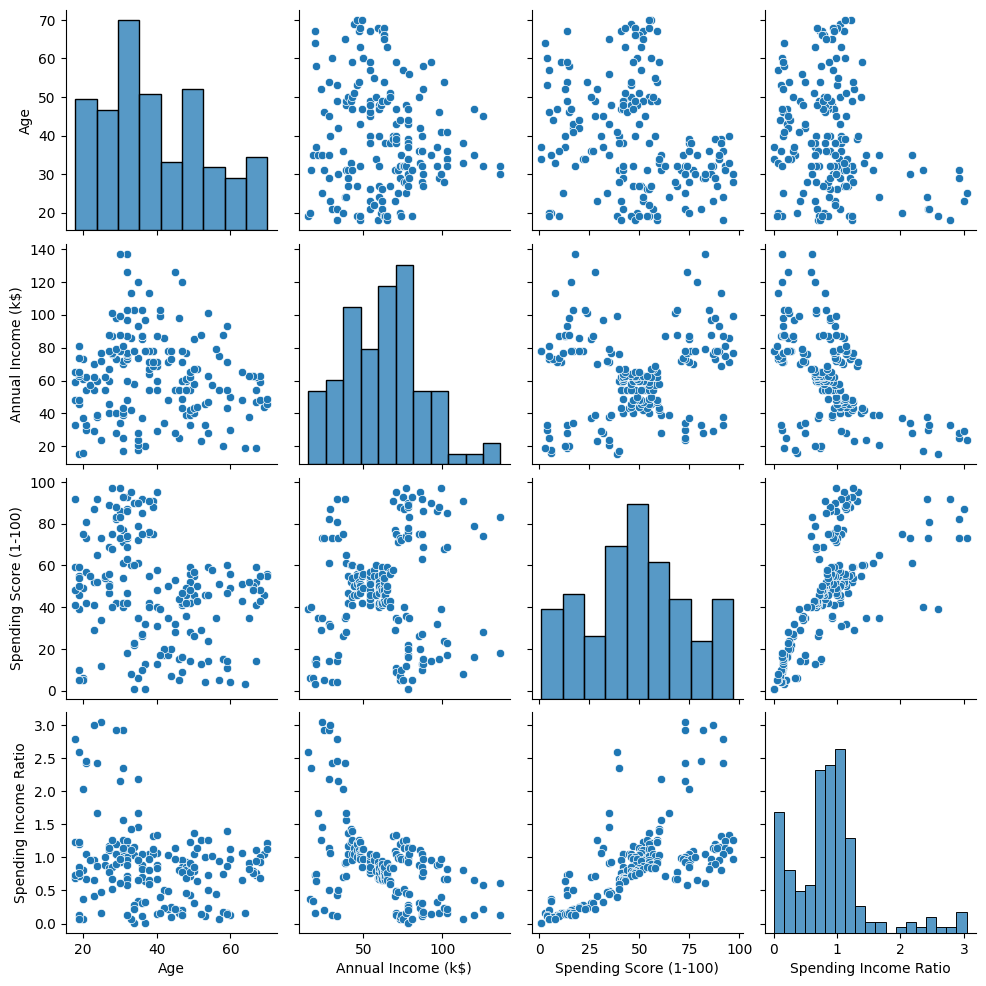

In [9]:
sns.pairplot(data)
plt.show()

Визуальное разбиение на кластеры наблюдается на графике зависимости признака "Annual Income (k$)" от признака "Spending Score (1-100)".

Рассмотрим этот график подробнее:

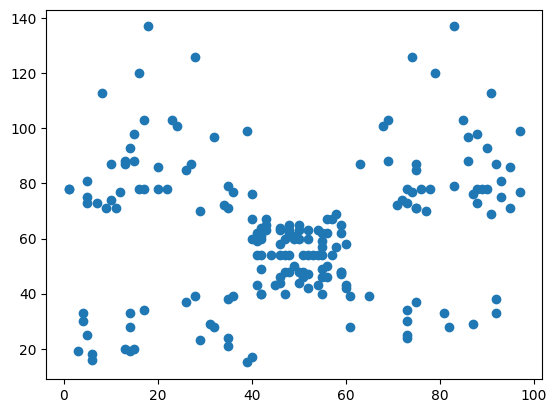

In [10]:
plt.scatter(data["Spending Score (1-100)"],data["Annual Income (k$)"])

Визуально наблюдаем 5 ярковыраженных кластеров (групп). Попробуем определить число k методом локтя.

### Метод локтя

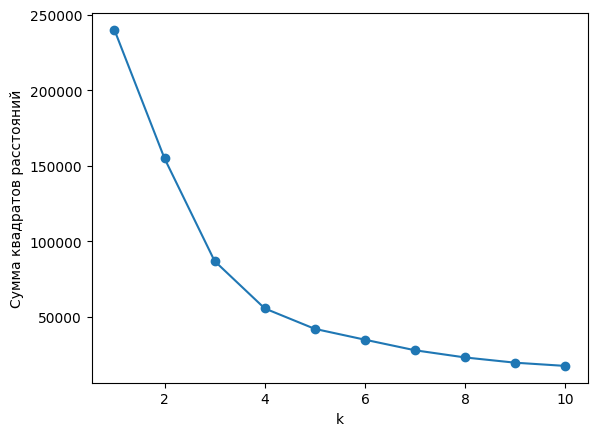

In [11]:
k_range = range(1, 11)
sse = []
for k in k_range:
    km = KMeans(n_clusters = k, n_init = 10)
    km.fit(data[['Spending Score (1-100)',"Annual Income (k$)"]])
    sse.append(km.inertia_)

plt.xlabel('k')
plt.ylabel('Сумма квадратов расстояний')

plt.plot(k_range, sse)
plt.scatter(k_range, sse)

Как мы видим, k = 5 является оптимальным значением числа групп.

## Кластеризация методом K-mean

Применим метод KMeans непосредственно для кластеризации:

In [12]:
km = KMeans(n_clusters = 5, n_init = 10)
y_predicted = km.fit_predict(data[["Spending Score (1-100)","Annual Income (k$)"]])
data["cluster"] = y_predicted
data.head()

,Genre,Age,Annual Income (k$),Spending Score (1-100),Spending Income Ratio,cluster
CustomerID,,,,,,
1,Male,19,15,39,2.600000,4
3,Female,20,16,6,0.375000,4
5,Female,31,17,40,2.352941,4
7,Female,35,18,6,0.333333,4
9,Male,64,19,3,0.157895,4


Получив разделение на кластеры, отобразим их для наглядности:

Text(0, 0.5, 'Annual Income')

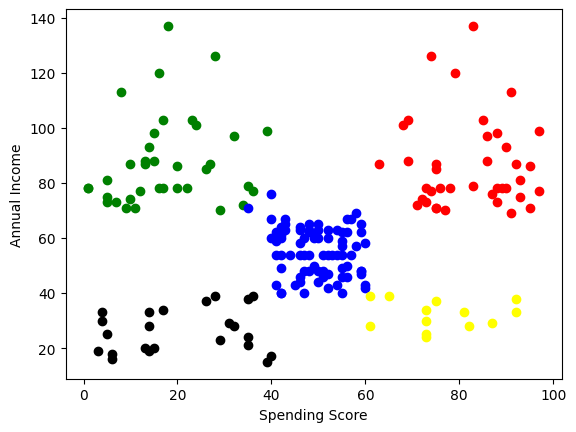

In [13]:
data1 = data[data.cluster == 0]
data2 = data[data.cluster == 1]
data3 = data[data.cluster == 2]
data4 = data[data.cluster == 3]
data5 = data[data.cluster == 4]

plt.scatter(data1["Spending Score (1-100)"], data1["Annual Income (k$)"], color='green')
plt.scatter(data2["Spending Score (1-100)"], data2["Annual Income (k$)"], color='blue')
plt.scatter(data3["Spending Score (1-100)"], data3["Annual Income (k$)"], color='red')
plt.scatter(data4["Spending Score (1-100)"], data4["Annual Income (k$)"], color='yellow')
plt.scatter(data5["Spending Score (1-100)"], data5["Annual Income (k$)"], color='black')

plt.xlabel('Spending Score')
plt.ylabel('Annual Income')

Каждый цвет обозначает соответствующий ему кластер. Предположение на основании графического метода оказалось справедливым.

## Вывод

В ходе исследования датасета о клиентах супермаркета были выполнены основные этапы предобработки данных и применен метод кластеризации KMeans.

Использование графических методов для определения оптимального количества кластеров позволило увидеть явно выраженные группы на графике зависимости "Annual Income" от "Spending Score". Метод локтя подтвердил предполагаемое количество кластеров.

Применение алгоритма KMeans кластеризации также выявило 5 ярко выраженных групп клиентов, что согласуется с графическими предположениями.

Визуализация кластеров на графике отобразила четкое разделение цветами на соответствующие кластеры, подтверждая успешную кластеризацию данных.

__Общий вывод__: выборка клиентов супермаркета распределилась на 5 основных групп на основе их оценок расходов и годового дохода.